In [1]:
#@title 1) 데이터 수집
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
file_url = 'https://raw.githubusercontent.com/Ruinenhaft/Project_space_titanic/main/data/train.csv'
df_raw = pd.read_csv(file_url)
#- PassengerId : 승객 고유 ID. gggg-pp 형태로 gggg는 그룹, pp는 그룹 내 번호. 그룹이 같으면 가족인 경우가 많음
#- HomePlanet : 고향 행성
#- CryoSleep : 냉동수면 상태 여부. 냉동수면 상태인 탑승객은 객실에 갇혀있음
#- Cabin : 객실 번호. deck/num/side 형태로 side는 P(Port) 혹은 S(Starboard)
#- Destination : 목적 행성
#- Age : 나이
#- VIP : VIP 서비스 신청했는지 여부
#- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck : 우주선 내 있는 해당 편의시설에 지불한 금액
#- Name : 이름과 성
#- Transported : 다른 차원으로 전이됐는지 여부. target

In [2]:
#@title 2) 데이터 전처리 과정-분석
df_raw.info() # 결측치 확인
df_raw.isna().sum()/len(df_raw) # 결측률 확인
df_raw.describe() # 통계수치 확인
df_raw.describe(include='O')
# 대략적인 분석
# HomePlanet        / Europa
#                   / Mars
#                   / Earth
#                   / 내림차순으로 생존률과 상관관계가 보이고, 소비량에서도 차이를 보임
# CryoSleep         / 냉동 수면 상태일때 생존여부와 매우 큰 관계가 보임.
# Cabin             / deck, side를 나눠서 유도변수 활용할것인지
# Destination       / 55 Cancri e
#                   / TRAPPIST-1e
#                   / PSO J318.5-22
#                   / 내림차순으로 나이, 소비량에 차이가 보임.
# Age               / 나이대별 소비패턴과 대조하여 예측할 것인지.
# VIP               / VIP여부와 소비패턴은 연관성이 커보이나 생존여부와는 큰 관계가 없어보임.
# RoomService       / 5개 컬럼 통합 해서 사용하기 전에 나이대별 소비패턴으로 활용하여 결측치 채울것인지
# FoodCourt         / 통합
# ShoppingMall      / 통합
# Spa               / 통합
# VRDeck            / 통합
# Name              / 컬럼 삭제.
# 
#
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, 나이를 제외한 부분은 데이터를 합성하여 하나의 column으로 변환.
# 아웃라이어 값이 존재하므로 스케일링 처리 필요.
# 아웃라이어 추출도 시각화 하여 근거로 제시해볼것.
# vip여부와 냉동수면상태의 관계 확인필요, 소비량과 생존률의 관계성은 크지 않음.
# 연령대별 냉동수면상태의 관계 확인필요.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [3]:
pd.set_option('display.max_rows', None)
df_raw.groupby('Age').mean() # 0~10살, 11~20살, 이런식으로 합쳐서 통계를 내야 볼만 할것같다.
df_raw.groupby('Destination').mean() # 목적지별 평균치.
df_raw.groupby('CryoSleep').mean() # 냉동 수면 상태일때 생존여부와 매우 큰 관계가 보임.
df_raw.groupby('VIP').mean() # VIP여부와 소비패턴은 연관성이 커보이나 생존여부와는 음의선형관계를 보임.
df_raw.groupby('HomePlanet').mean() # VIP여부와 소비패턴은 연관성이 커보이나 생존여부와는 음의선형관계를 보임.

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
HomePlanet,,,,,,,
Earth,26.07,136.94,137.23,133.87,142.78,138.13,0.42
Europa,34.42,145.23,1503.21,151.13,848.06,875.77,0.66
Mars,29.30,552.90,54.36,308.45,110.22,47.44,0.52


In [4]:
corr = df_raw.corr(method='pearson')
print(corr)

               Age  RoomService  FoodCourt  ShoppingMall   Spa  VRDeck  \
Age           1.00         0.07       0.13          0.03  0.12    0.10   
RoomService   0.07         1.00      -0.02          0.05  0.01   -0.02   
FoodCourt     0.13        -0.02       1.00         -0.01  0.22    0.23   
ShoppingMall  0.03         0.05      -0.01          1.00  0.01   -0.01   
Spa           0.12         0.01       0.22          0.01  1.00    0.15   
VRDeck        0.10        -0.02       0.23         -0.01  0.15    1.00   
Transported  -0.08        -0.24       0.05          0.01 -0.22   -0.21   

              Transported  
Age                 -0.08  
RoomService         -0.24  
FoodCourt            0.05  
ShoppingMall         0.01  
Spa                 -0.22  
VRDeck              -0.21  
Transported          1.00  


In [5]:
# vip, CryoSleep,Transported 값 비율 확인.
print(df_raw['VIP'].value_counts()) # vip가 4% 가량으로 매우 적은수
print(df_raw['CryoSleep'].value_counts()) # 냉동수면은 5:3 비율
print(df_raw['Transported'].value_counts()) # 생종률은 5:5 정도의 비율

False    8291
True      199
Name: VIP, dtype: int64
False    5439
True     3037
Name: CryoSleep, dtype: int64
True     4378
False    4315
Name: Transported, dtype: int64


In [6]:
#@title 2) 데이터 전처리 과정 - 전처리 시작
# 전처리는 결측치 중위값으로 처리
# 컬럼명 소문자 통일
# object 타입 컬럼 처리방식 도출해보기.

In [7]:
df_raw.columns = df_raw.columns.str.lower() # 컬럼명 소문자 통일.
df_raw['cryosleep'] = df_raw['cryosleep'].fillna(0) # 전처리는 결측치 중위값으로 처리
df_raw['vip'] = df_raw['vip'].fillna(0)
df_raw['cabin'] = df_raw['cabin'].fillna(df_raw['cabin'].mode()[0]) # object 타입 컬럼 처리
df_raw['homeplanet'] = df_raw['homeplanet'].fillna(df_raw['homeplanet'].mode()[0])
df_raw['destination'] = df_raw['destination'].fillna(df_raw['destination'].mode()[0])
df_raw['shoppingmall'] = df_raw['shoppingmall'].fillna(df_raw['shoppingmall'].median())
df_raw['vrdeck'] = df_raw['vrdeck'].fillna(df_raw['vrdeck'].median())
df_raw['foodcourt'] = df_raw['foodcourt'].fillna(df_raw['foodcourt'].median())
df_raw['spa'] = df_raw['spa'].fillna(df_raw['spa'].median())
df_raw['roomservice'] = df_raw['roomservice'].fillna(df_raw['roomservice'].median())
df_raw['age'] = df_raw['age'].fillna(df_raw['age'].median())

In [8]:
# 남은 결측치 name, name은 drop하고 passengerid 활용하여 동료로 탑승한 여부를 새 탭으로 지정하여 1, 0값으로 도출.
# passengerid 앞 네자리를 잘라서 전체값과 비교하여 같은 값이 있으면 1. 아니면 0 출력.
def passengerid_split(value):
    return value.split('_')[0]

In [9]:
df_train1 = df_raw.copy() # 데이터 카피, 기본 전처리 보존하고 내가 생각하는 방식으로

In [10]:
df_train1['id_coop'] = df_train1['passengerid'].apply(passengerid_split) # 동료여부를 확인하기 위한 컬럼인덱스 확보
coop_map = {} # 분류 위한 딕셔너리 생성
for number in df_train1['id_coop']:
    try : coop_map[number] += 1 # for문을 통해 list의 요소를 하나씩 꺼내여, coop_cnt 딕셔너리에 넣는다.
    except : coop_map[number] = 1 # 이때 딕셔너리에 이미 존재하는 key값이라면 , try문 실행, value +1 , 없으면 expept 값 1.
# coop_map에 매칭되는 id_coop을 찾아 값을 넣어준다.
df_train1['id_coop'] = df_train1['id_coop'].map(coop_map)
df_train1.drop('name', axis = 1, inplace=True) # 가족관계는 동료값으로 추출했으니 배제
df_train1.drop('passengerid', axis = 1, inplace=True) # id 추출했으니 passengerid 배제

In [11]:
# cabin 배치칸 몇번칸인지, 안쪽인지 밖쪽인지 나누고
# homeplanet, destination 더미화
# cryosleep, vip, transported True 1, False 0 분리.
cab = df_train1["cabin"].apply(lambda x: x.split("/"))
df_train1["c_1"] = cab.apply(lambda x: x[0])
df_train1["c_2"] = cab.apply(lambda x: int(x[1]))
df_train1["c_3"] = cab.apply(lambda x: x[2])
df_train1 = pd.get_dummies(df_train1, columns = ['c_1', 'c_3'])
df_train1 = pd.get_dummies(df_train1, columns = ['homeplanet', 'destination'])
df_train1 = pd.get_dummies(df_train1, columns = ['cryosleep', 'vip', 'transported'], drop_first=True)
# cabin 삭제
df_train1.drop('cabin', axis = 1, inplace=True)

In [12]:
df_train1.corr()

,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,id_coop,c_2,c_1_A,c_1_B,...,c_3_S,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True
age,1.00,0.07,0.13,0.03,0.12,0.10,-0.18,-0.13,0.07,0.10,...,0.01,-0.20,0.22,0.02,0.02,-0.03,0.00,-0.07,0.09,-0.07
roomservice,0.07,1.00,-0.02,0.05,0.01,-0.02,-0.04,-0.01,-0.02,-0.06,...,-0.01,-0.14,-0.07,0.25,-0.02,-0.06,0.06,-0.24,0.06,-0.24
foodcourt,0.13,-0.02,1.00,-0.01,0.22,0.22,0.03,-0.18,0.12,0.16,...,0.02,-0.22,0.37,-0.12,0.13,-0.07,-0.08,-0.21,0.13,0.05
shoppingmall,0.03,0.05,-0.01,1.00,0.01,-0.01,-0.04,0.00,-0.02,-0.01,...,-0.02,-0.07,-0.02,0.11,-0.01,-0.03,0.03,-0.21,0.02,0.01
spa,0.12,0.01,0.22,0.01,1.00,0.15,0.02,-0.13,0.06,0.11,...,0.01,-0.16,0.27,-0.09,0.08,-0.05,-0.03,-0.20,0.06,-0.22
vrdeck,0.10,-0.02,0.22,-0.01,0.15,1.00,0.01,-0.14,0.10,0.12,...,-0.01,-0.15,0.28,-0.11,0.09,-0.04,-0.05,-0.19,0.12,-0.20
id_coop,-0.18,-0.04,0.03,-0.04,0.02,0.01,1.00,-0.05,0.04,0.08,...,0.02,-0.10,0.13,-0.02,0.06,-0.06,-0.02,0.08,0.00,0.08
c_2,-0.13,-0.01,-0.18,0.00,-0.13,-0.14,-0.05,1.00,-0.19,-0.27,...,-0.03,0.37,-0.48,0.06,-0.14,0.10,0.06,-0.04,-0.10,-0.04
c_1_A,0.07,-0.02,0.12,-0.02,0.06,0.10,0.04,-0.19,1.00,-0.05,...,0.01,-0.19,0.30,-0.09,0.09,-0.05,-0.05,-0.03,0.13,-0.00
c_1_B,0.10,-0.06,0.16,-0.01,0.11,0.12,0.08,-0.27,-0.05,1.00,...,0.02,-0.34,0.54,-0.16,0.17,-0.10,-0.09,0.12,0.07,0.14


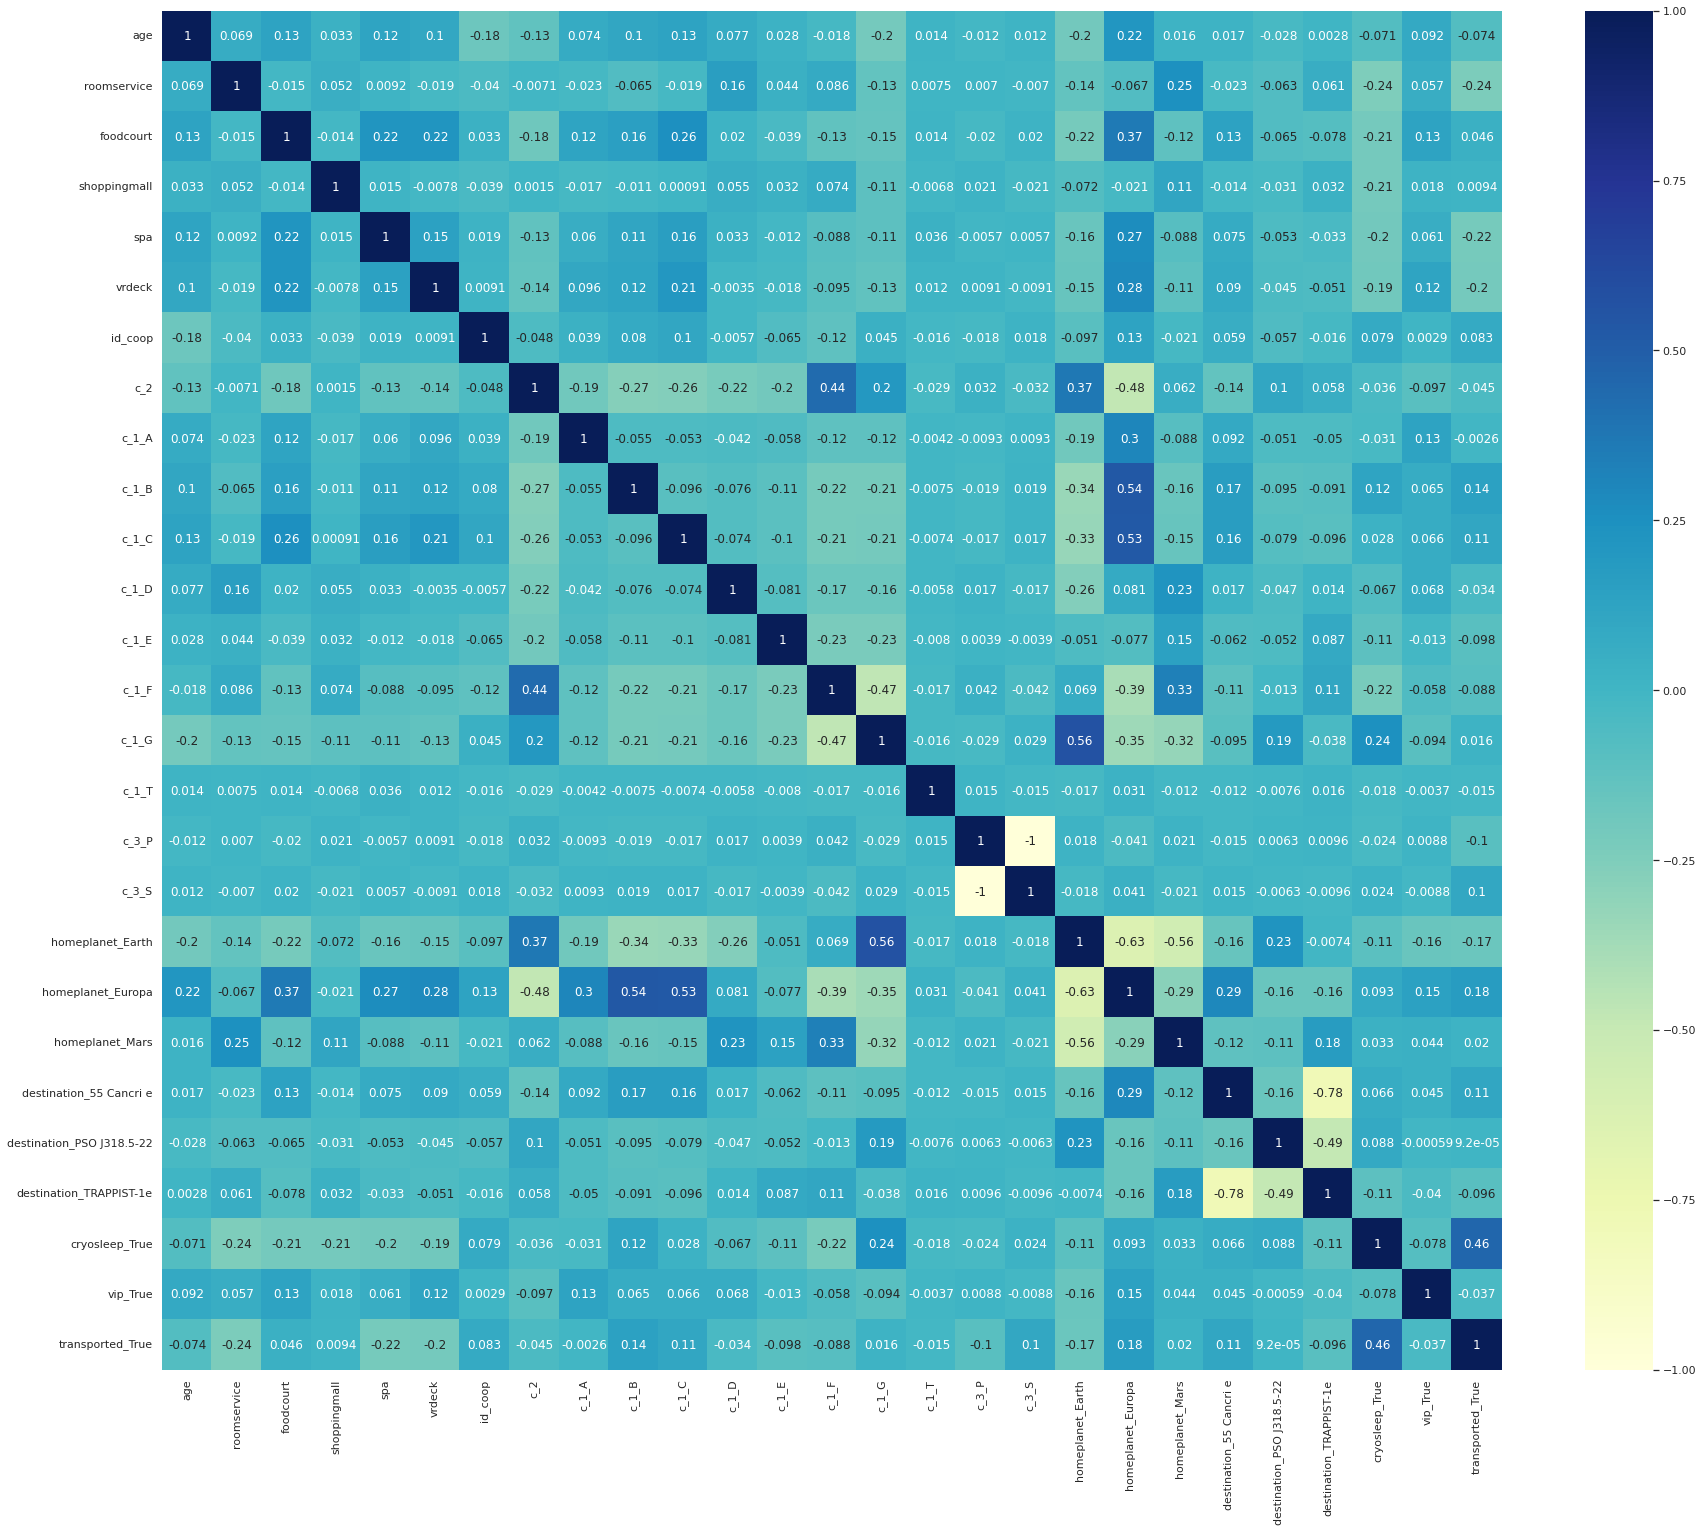

In [13]:
# 상관관계 확인
df_train1_corr = df_train1.corr()
plt.figure(figsize=(30, 25))
sns.set(font_scale=1)
train_obj_heat = sns.heatmap(df_train1_corr, annot=True, fmt='.2g', cmap='YlGnBu', vmin=-1, vmax=1)
plt.show(train_obj_heat)

In [14]:
#@title 2) 데이터 전처리 과정 - 상관관계를 확인하기 위한 1차 전처리 완료.
# 최대한 모든 지표를 살려서 출력했습니다.
# name은 drop하고
# passengerid 활용하여 동료로 탑승한 수 생성                          -> id_coop
# cabin 배치칸 몇번칸인지, 안쪽인지 밖쪽인지 나누고 더미              -> c_1, c_2, c_3 /로 나눈 순서대로
# homeplanet, destination 더미화
# cryosleep, vip, transported True 1, False 0 분리.

# 동면 정도면 0.46으로 연관성을 가지고
# 두번 째로 0.18 Europa 출신이냐.
# Europa 출신 B, C 칸에 주로 탑승하고 있었다.

In [15]:
# 결측치는 중앙값으로 처리.
# 최빈값 처리.
# 여기서 더 진행한다면..

Text(0.5, 0, 'age')

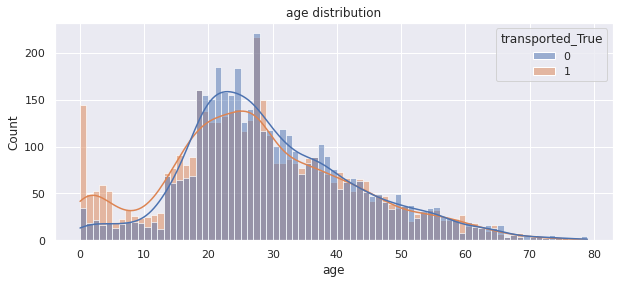

In [16]:
# 나이
plt.figure(figsize=(10, 4))
sns.histplot(data=df_train1, x='age', hue='transported_True', binwidth=1, kde=True)
plt.title('age distribution')
plt.xlabel('age')

In [17]:
# 0~18세 까지는 이동된 사람 비중이 많다.
# 18 ~ 25세 까지는 이동되지 못한 사람 비중이 많다.
# 25세 이후는 대체로 비슷하다.
# 성인인지 아닌지로 나눠서 age 유도 변수를 생성해주는것은 어떨지
# 나이가 18세 이하면 1, 18세 이상이면 0.
df_train1['age_adult'] = np.nan
df_train1.loc[df_train1['age'] < 18, 'age_adult'] = 0
df_train1.loc[df_train1['age'] >= 18, 'age_adult'] = 1

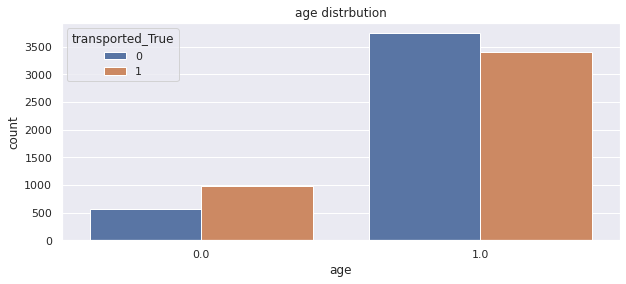

In [18]:
# 성인, 비성인으로 나누어 의미있는 데이터 도출
plt.figure(figsize=(10, 4))
sns.countplot(data = df_train1, x='age_adult', hue='transported_True')
plt.title('age distrbution')
plt.xlabel('age')
plt.show()

In [19]:
df_train1.drop('age',axis = 1, inplace=True)

In [20]:
# 지출 토탈
df_train1['total_exp'] = df_train1[['roomservice','foodcourt','shoppingmall','spa','vrdeck']].sum(axis=1)

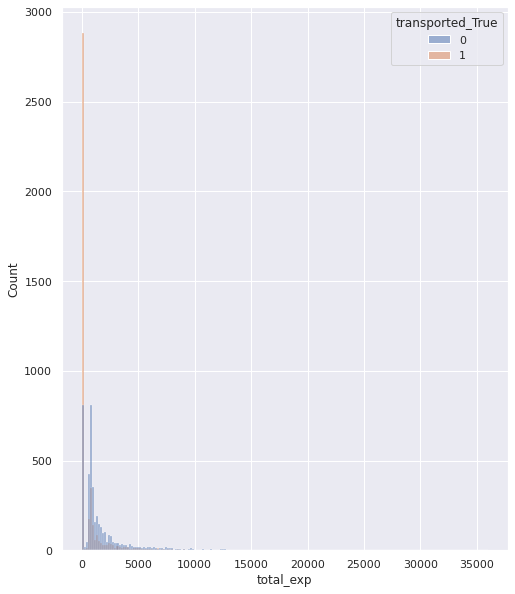

In [21]:
fig = plt.figure(figsize=(8, 10))
sns.histplot(data=df_train1, x='total_exp', hue='transported_True', bins=200)
plt.show()

In [22]:
# 지출이 0인사람의 생존확률이 높음.
# 0, 1로 나누어 특징을 간소화.
df_train1['exp_binary'] = np.nan
df_train1.loc[df_train1['total_exp'] > 0, 'exp_binary'] = 1
df_train1.loc[df_train1['total_exp'] == 0, 'exp_binary'] = 0 

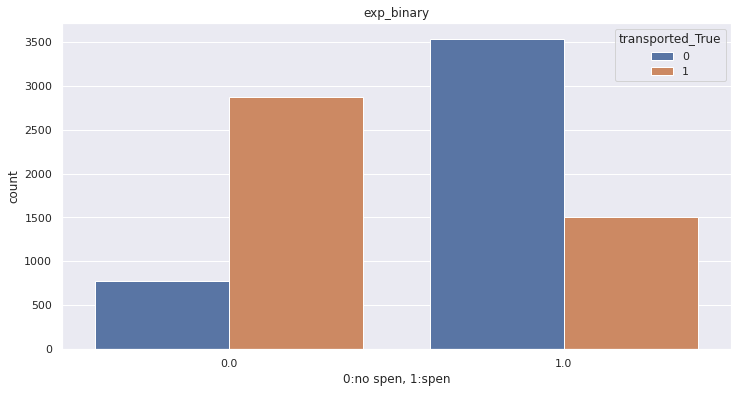

In [23]:
# 지출 유무로 나누어 데이터 도출
plt.figure(figsize=(12, 6))
sns.countplot(data = df_train1, x='exp_binary', hue='transported_True')
plt.title('exp_binary')
plt.xlabel('0:no spen, 1:spen')
plt.show()

In [24]:
df_train1.drop(['roomservice','foodcourt','shoppingmall','spa','vrdeck','total_exp'], axis=1, inplace=True)

In [25]:
df_train1.head()

,id_coop,c_2,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,...,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True,age_adult,exp_binary
0,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1.00,0.00
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1.00,1.00
2,2,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1.00,1.00
3,2,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1.00,1.00
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0.00,1.00


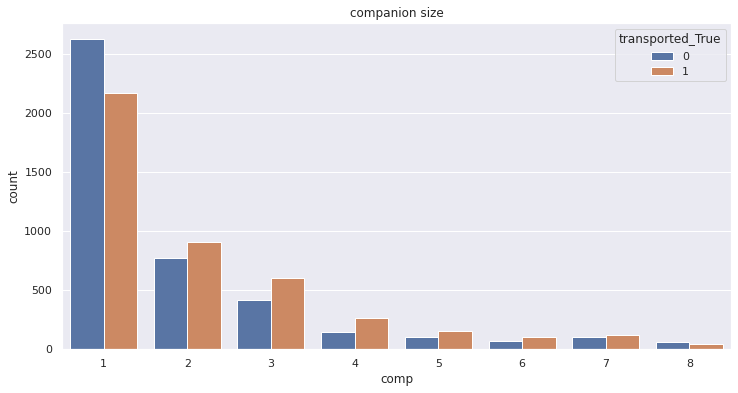

In [26]:
# 동료 규모에 따른 생존률
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train1, x='id_coop', hue='transported_True')
plt.title('companion size')
plt.xlabel('comp')
plt.show()


In [27]:
# 혼자일때 생존률이 높은편, 이진화 하여
df_train1['id_coop_solo'] = np.nan
df_train1.loc[df_train1['id_coop'] > 1, 'id_coop_solo'] = 0
df_train1.loc[df_train1['id_coop'] == 1, 'id_coop_solo'] = 1 
df_train1.drop('id_coop', axis=1, inplace=True)

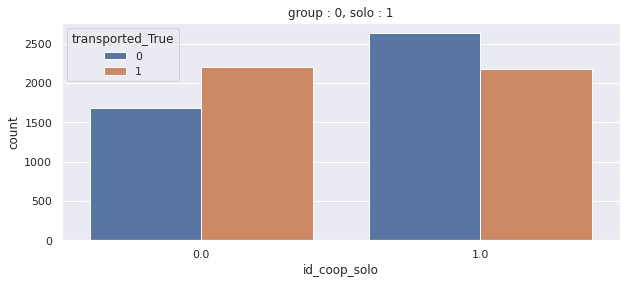

In [28]:
plt.figure(figsize=(10,4)) 
sns.countplot(data=df_train1, x='id_coop_solo', hue='transported_True') 
plt.title('group : 0, solo : 1')
plt.show()

In [32]:
pd.set_option('display.max_columns',None)

In [33]:
df_train1.head()

,c_2,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,c_3_P,c_3_S,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True,age_adult,exp_binary,id_coop_solo
0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1.00,0.00,1.00
1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1.00,1.00,1.00
2,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1.00,1.00,0.00
3,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1.00,1.00,0.00
4,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0.00,1.00,1.00


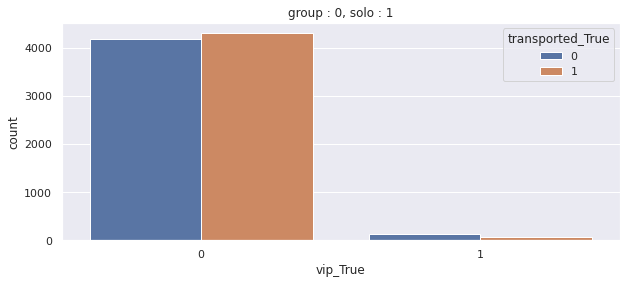

In [34]:
# 정리 필요한부분.
# 1, 좌석코드
# 2, vip
plt.figure(figsize=(10,4)) 
sns.countplot(data=df_train1, x='vip_True', hue='transported_True') 
plt.title('group : 0, solo : 1')
plt.show()

In [35]:
# vip파트는 큰 영향력이 없으니 제외.
df_train1.drop('vip_True', axis=1, inplace=True)

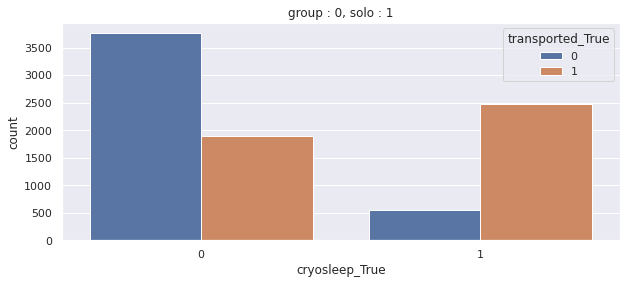

In [36]:
# 정리 필요한부분.
# 냉동수면 여부
plt.figure(figsize=(10,4)) 
sns.countplot(data=df_train1, x='cryosleep_True', hue='transported_True') 
plt.title('group : 0, solo : 1')
plt.show()

In [37]:
# 여기까지 하고 모델 선택(분류)
# 1. KNN
# 2. 로지스틱 회귀
# 3. 랜덤포레스트
# 4. XGBoost
# 5. LightGBM

In [40]:
# 인풋, 타겟 분리
from sklearn.model_selection import train_test_split
input_train, input_test, target_train, target_test = train_test_split(
    df_train1.drop('transported_True', axis=1),
    df_train1.transported_True, test_size=0.2, random_state=100
)

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(input_train, target_train)
pred = knn.predict(input_test)

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(target_test, pred)

0.6175963197239793

In [44]:
def tuning(n):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(input_train, target_train)
    pred = knn.predict(input_test)
    score = accuracy_score(target_test, pred)
    return score

In [45]:
scores = [(i, tuning(i)) for i in range(1, 21)]
sorted(scores, key=lambda x: x[1], reverse=True)

[(10, 0.6371477860839563),
 (9, 0.6348476135710178),
 (6, 0.6342725704427832),
 (8, 0.6336975273145485),
 (13, 0.633122484186314),
 (14, 0.633122484186314),
 (12, 0.6319723979298447),
 (15, 0.6313973548016101),
 (16, 0.6313973548016101),
 (18, 0.6313973548016101),
 (11, 0.6302472685451409),
 (7, 0.6290971822886716),
 (17, 0.6279470960322024),
 (3, 0.6250718803910293),
 (20, 0.6239217941345601),
 (4, 0.6187464059804485),
 (5, 0.6175963197239793),
 (19, 0.6158711903392754),
 (2, 0.6124209315698678),
 (1, 0.5968947671075331)]

In [51]:
# 2. 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(input_train, target_train)
pred = model.predict(input_test)

In [52]:
accuracy_score(target_test, pred)

0.7590569292696953

In [54]:
# 3. 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(input_train, target_train) # 학습
train_pred = model.predict(input_test) # 훈련셋 예측 (잘 학습되었나? 과최적화, 오버피팅?)

In [56]:
accuracy_score(target_test, train_pred)

0.6940770557791834

In [57]:
# 4. XGBoost
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators=500, max_depth=5, random_state=100)
model.fit(input_train, target_train)
pred = model.predict(input_test)
accuracy_score(target_test, pred)

0.7515813686026452

In [ ]:
#parameter = {
#    'learning_rate': [0.01, 0.1, 0.3], # 경사하강법 : '매개변수' -> 최소오차 -> 보폭 크기
#    'max_depth': [5, 7, 10], # 트리의 깊이 (오버피팅)
#    'subsample': [0.5, 0.7, 1], # 추출할 데이터 비율
#    'n_estimators': [300, 500, 1000] # 트리 개수
#}
#from sklearn.model_selection import GridSearchCV
#model = xgb.XGBClassifier()
#gs_model = GridSearchCV(model, parameter, n_jobs=-1, scoring='f1', cv = 5)
#gs_model.fit(input_train, target_train)

In [ ]:
#!pip install mlxtend --quiet
#import joblib
#joblib.dump(gs_model, 'gs_model.pkl')
#pred = gs_model.predict(input_test)

In [59]:
# 5. XGBoost
import lightgbm as lgb
model = lgb.LGBMClassifier(random_state=100)
model.fit(input_train, target_train)
pred = model.predict(input_test)
accuracy_score(target_test, pred)

0.7567567567567568

In [ ]:
# 일단은 각 모델 디폴트만 돌려보고.
# 예측률이 엉망이니 전처리 부족한점 받아본다음에 다시 시행
# 전처리 보충 후 하이퍼파라미터값 테스트 해볼것.